### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that are not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [7]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster, UserLog
from django.contrib.auth.models import User
from django.db.models.functions import Trunc
from django.db.models import DateField

# Helpers
import numpy as np
import pickle
import pandas as pd

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Learning
from clustering import Clustering
# from plot2d import Plot2D
from questions.sampling import get_next_sample

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport

%matplotlib inline

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=132)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print(problems.count())
problems = Problem.objects.filter(id__lte=132)
problems.count()

591


132

In [3]:
solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')

In [4]:
solutions_obj.count()

54

In [5]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
# cursor = db.conn.cursor()
docs = []
docs_id = []
# doc_category = []
errors = []
questions = []
solutions = []

# lendo os dados
# cursor.execute("""
# SELECT solution.id, solution.content, problem.content, problem.category FROM solution, problem where solution.problem_id = problem.id;
# """)


for sol in solutions_obj:
    file = io.StringIO(sol.content)
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (sol.id))
    
    if doc == []:
        continue
    docs.append(' '.join(doc))
    docs_id.append(sol.id)
#     doc_category.append(row[-1])
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 54 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [6]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
#                              stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(54, 17)

In [7]:
feature_names = vectorizer.get_feature_names()
feature_names

['append',
 'def',
 'elif',
 'else',
 'false',
 'for',
 'if',
 'in',
 'int',
 'join',
 'len',
 'not',
 'number',
 'range',
 'return',
 'split',
 'true']

In [8]:
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
docs_id = np.asarray(docs_id)[~(train_data_features==0).all(1)]
# doc_category = np.asarray(doc_category)[~(train_data_features==0).all(1)]
questions = np.asarray(questions)[~(train_data_features==0).all(1)]
docs_id.shape

(54,)

### Cluster solutions

2209808447


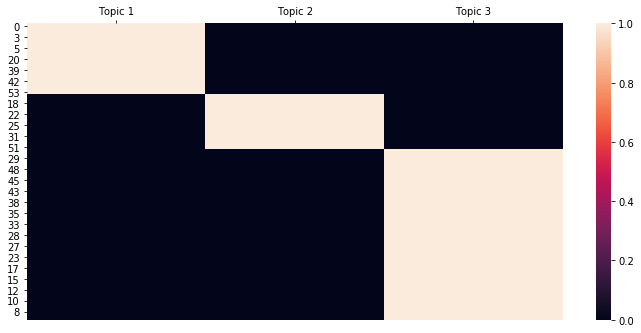

Count per class:
Topic 1: 13
Topic 2: 10
Topic 3: 31


In [9]:
# clustering = Clustering(handler.X, )
clustering = Clustering(solution_sample, 3)
clustering.seed = 2209808447
#2124056991
#232156180
#2539469571
# clustering.seed = 0
# clustering._generate_random_state()
model, document_topic, word_topic = clustering.gaussian_mixture()
print(clustering.seed)
clustering.plot_topic_distribution()

print("Count per class:")
counts = np.unique(clustering.document_topic.argmax(axis=1), return_counts=True)
for i in range(clustering.k):
    print("Topic %d: %d" % ((i+1), counts[1][i]))

In [10]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [11]:
print("\nWords per topic:")
feature_names = vectorizer.get_feature_names()
print_top_words(word_topic, feature_names, 10)


Words per topic:
Topic #1: int return def join split for in if append len
Topic #2: elif return if def in else int number for not
Topic #3: in return for def if range number else false true



### Get next sample

Set initial matrices

In [12]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
Y = np.zeros(clustering.document_topic.shape)
for idx in range(Y.shape[0]):
    Y[idx, Y_col[idx]] = 1

# Create W as a similarity matrix
W = cosine_similarity(clustering.X) # nS x nS
print(W.shape)

with open('similarity.pkl', 'wb') as picklefile:
    pickle.dump(W, picklefile)

# Set L as an unlabelled set
L = []

(54, 3)
(54, 54)


#### Visualization
Reduce to 2 dimensions using TSNE

1688129853


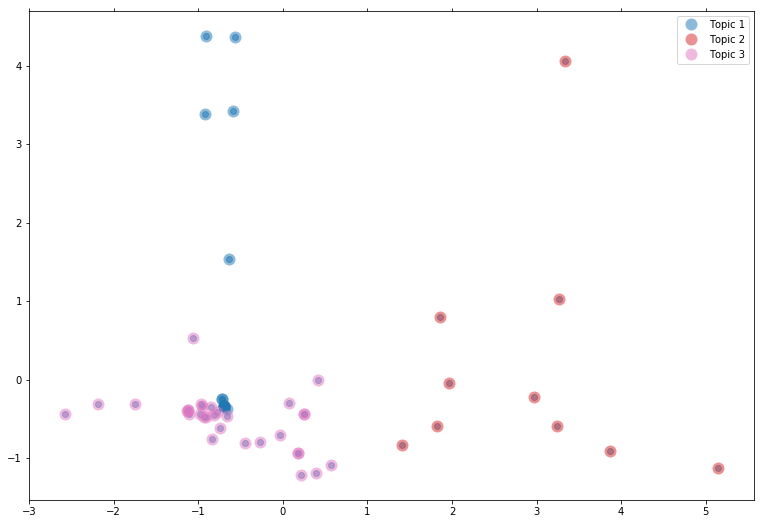

In [16]:
# %%time
# cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
handler._generate_random_state()
# handler.seed = 14875623
handler.reduce(solution_sample)
print(handler.seed)
handler.plot(show_clusters=True)

sample = handler.X
y = clustering.document_topic.argmax(axis=1)

# fig = plt.figure(figsize=(10,5))
# plt.scatter(x=sample[:,0], y=sample[:,1], c=y, s=100)

### Check if clusters are the same

In [17]:
solutions_obj = np.array(Solution.objects.filter(problem__in=problems, ignore=False).order_by('id').values_list('cluster', flat=True))
clusters = clustering.document_topic.argmax(axis=1)
(solutions_obj == clusters).all()

True

In [18]:
clustering.model

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=2209808447, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [19]:
handler.solution_tsne

PCA(copy=True, iterated_power='auto', n_components=3, random_state=1688129853,
  svd_solver='auto', tol=0.0, whiten=False)

### Check professor distribution

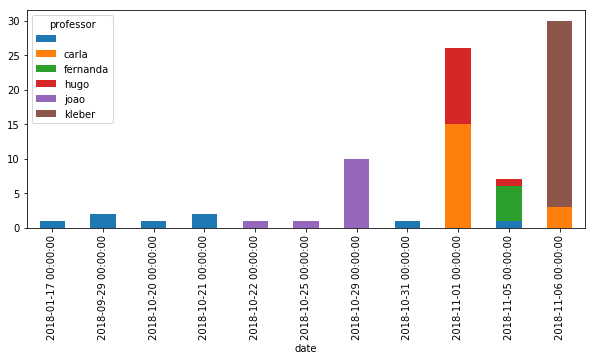

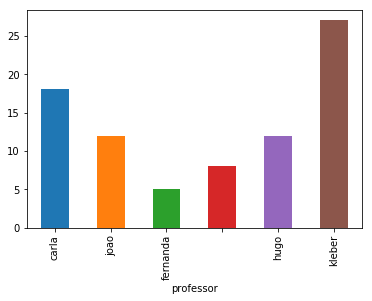

In [20]:
users = UserProfile.objects.all().values('professor', date=Trunc('user__date_joined', 'day', output_field=DateField())).annotate(value=Count('professor'))
df = pd.DataFrame(list(users))
df = df.set_index(['date', 'professor']).value

# Plot users x professors x date
df.unstack().plot(kind='bar', stacked=True, figsize=(10,4))

# Plot users x professors
plt.figure()
professor_count = UserProfile.objects.all().values('professor').annotate(value=Count('professor'))
df = pd.DataFrame(list(professor_count))
df = df.set_index(df['professor']).value
df.plot(kind='bar')

In [21]:
old_X = handler.X.copy()
old_xs, old_ys = handler.xs, handler.ys
old_category = handler.doc_category
old_id = handler.doc_id
old_X.shape

(54, 3)

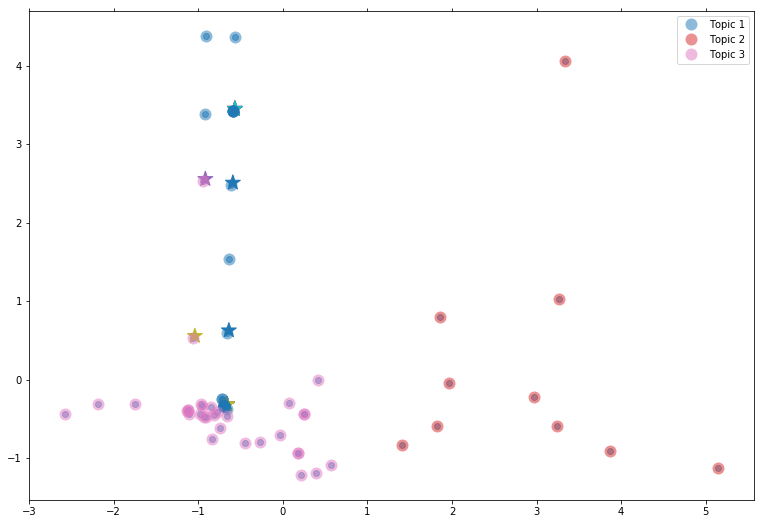

In [87]:
# 118 - Digit Sum
problem = Problem.objects.get(pk=118)
solution = Solution.objects.filter(problem=118, ignore=False)
# USER: jotavesilva@poli.ufrj.br
userlog = UserLog.objects.filter(problem=problem, outcome="P").exclude(user__userprofile__professor='').distinct().values_list('solution', flat=True)
# solutions = UserLog.objects.filter(problem=problem, user__userprofile__professor='').values('user__username').distinct()

test_data_features = vectorizer.transform(list(userlog))
pos = handler.solution_tsne.transform(test_data_features.toarray())

# Get topic
topic = []
predict_topics = clustering.model.predict(test_data_features.toarray())
for item in predict_topics:
    topic.append("Topic %s" % (item+1))

# Original points
handler.X = old_X.copy()
# Add user solution to the original points
handler.X = np.vstack((handler.X, pos))
handler.xs, handler.ys = handler.X[:, 0], handler.X[:, 1]

# Add also as doc_id and category
handler.doc_id = old_id.copy()
handler.doc_id = np.hstack((handler.doc_id, np.arange(-1, -len(userlog)-1, -1)))
handler.doc_category = old_category.copy()
handler.doc_category.extend(topic)

highlight = []
highlight = list(range(old_X.shape[0], handler.X.shape[0]))
for item in solution:
    idx = np.argwhere(handler.doc_id == item.pk)
    highlight.append(idx[0][0])
    
handler.plot(show_clusters=True, highlight=highlight)

In [183]:
similarity_outcome = []
position = {}

for outcome in ("P", "F"):
    userlog = UserLog.objects.filter(problem=problem, outcome=outcome).exclude(user__userprofile__professor='').distinct().values_list('solution', flat=True)
    test_data_features = vectorizer.transform(list(userlog))
#     print(test_data_features.shape)

    solution_pk, solution_cluster = list(zip(*(list(Solution.objects.filter(problem=118, ignore=False).order_by('cluster').values_list('pk', 'cluster')))))
    find = lambda x: train_data_features[np.argwhere(handler.doc_id == x)][0][0]
    train_feat = np.array(list(map(find, solution_pk)))
#     print(train_feat.shape)

    position[outcome] = handler.solution_tsne.transform(test_data_features.toarray())
    predict_topics = clustering.model.predict(test_data_features.toarray())

    # Create similarity matrix
    similarity = cosine_similarity(test_data_features, train_feat) # nS x nS
#     print(similarity.shape)

    # Using max similarity to one of the available solutions
    complete_dict = lambda x: {"type": "max", "outcome": outcome, "value": x}
    similarity_outcome.extend(list(map(complete_dict, np.max(similarity, axis=1))))
#     print(similarity_max.shape)

    # Using similarity to the same solution that is in your cluster
    # find = lambda x: np.argwhere(np.asarray(solution_cluster) == x)[0][0]
    find = lambda x: np.asarray(solution_cluster) == x
    complete_dict = lambda x: {"type": "cluster", "outcome": outcome, "value": x}
    similarity_outcome.extend(list(map(complete_dict, similarity[np.array(list(map(find, predict_topics)))])))
#     print(similarity_cluster.shape)
    
df = pd.DataFrame(similarity_outcome)

In [ ]:
solpos = handler.solution_tsne.transform(train_feat)

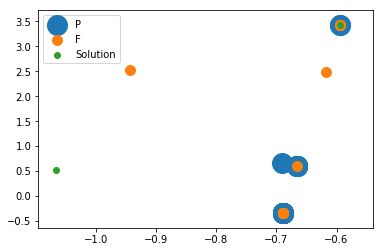

In [107]:
plt.scatter(x=position["F"][:,0], y=position["F"][:,1], s=400, label="P")
plt.scatter(x=position["P"][:,0], y=position["P"][:,1], s=100, label="F")
plt.scatter(x=solpos[:,0], y=solpos[:,1], label="Solution")
plt.legend()

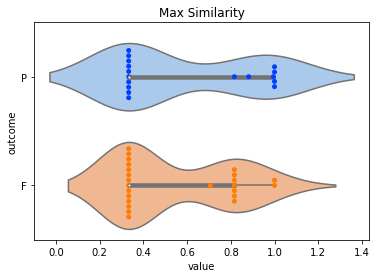

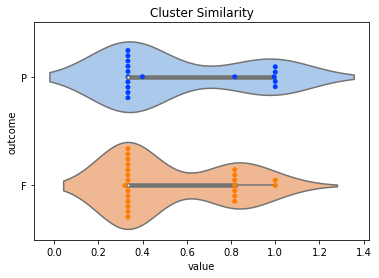

In [184]:
sns.set_palette("bright")
ax = sns.swarmplot(x='value', y='outcome', data=df[df['type'] == 'max']).set_title("Max Similarity")
# sns.color_palette("RdBu", n_colors=7)
sns.set_palette("pastel")
ax = sns.violinplot(x='value', y='outcome', data=df[df['type'] == 'max'])

plt.figure()
sns.set_palette("bright")
ax = sns.swarmplot(x='value', y='outcome', data=df[df['type'] == 'cluster']).set_title("Cluster Similarity")
# sns.color_palette("RdBu", n_colors=7)
sns.set_palette("pastel")
ax = sns.violinplot(x='value', y='outcome', data=df[df['type'] == 'cluster'])

In [35]:
for item in userlog:
    print("%s - %s" % (item.user, item.outcome))
    print(item.solution)

jotavesilva@poli.ufrj.br - P
# Complete your function using this header
def digit_sum(digit):
    soma = digit + int(str(digit)+str(digit)) + int(str(digit)+str(digit)+str(digit)) + int(str(digit)+str(digit)+str(digit)+str(digit))
    return soma
leopacheco@poli.ufrj.br - P
# Complete your function using this header
def digit_sum(digit):
    val1=digit
    val2= digit + digit*10
    val3= digit + digit*10 + digit*100
    val4= digit + digit*10 + digit*100  + digit*1000 
    return (val1+val2+val3+val4)
ianetab@hotmail.com - P
# Complete your function using this header
def digit_sum(digit):
    return digit+(10*digit)+digit+((100*digit)+10*digit)+digit+(((1000*digit)+100*digit)+10*digit)+digit
pedrohbshbs@gmail.com - P
# Complete your function using this header
def digit_sum(a):
    return a+a*11+a*111+a*1111
beatriz-onofre@hotmail.com - P
# Complete your function using this header
def digit_sum(digit):
    soma= digit*1 + digit*11 + digit*111 + digit*1111
    return soma
bernardo.smott

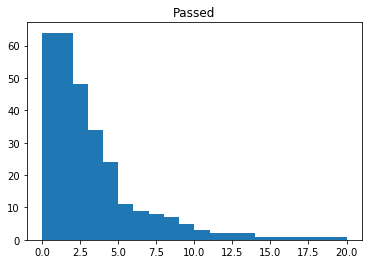

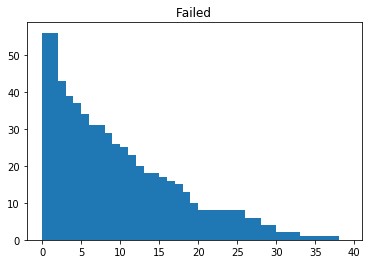

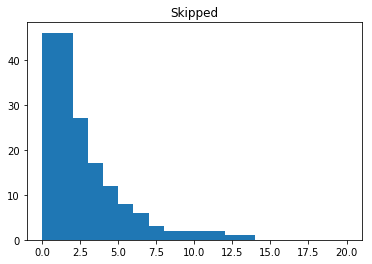

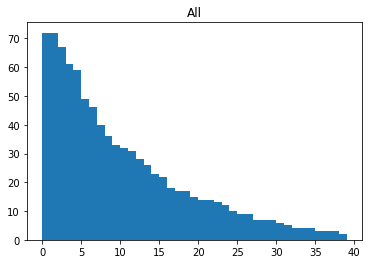

In [36]:
logs = UserLog.objects.filter(outcome="P").exclude(user__userprofile__professor='').values_list('user').annotate(count=Count('user'))
passed_count = list(zip(*logs))[1]
logs = UserLog.objects.filter(outcome="F").exclude(user__userprofile__professor='').values_list('user').annotate(count=Count('user'))
failed_count = list(zip(*logs))[1]
logs = UserLog.objects.filter(outcome="S").exclude(user__userprofile__professor='').values_list('user').annotate(count=Count('user'))
skipped_count = list(zip(*logs))[1]
logs = UserLog.objects.exclude(user__userprofile__professor='').values_list('user').annotate(count=Count('user'))
all_count = list(zip(*logs))[1]
plt.figure()
plt.title("Passed")
plt.hist(passed_count, bins=list(range(21)), cumulative=-1);
plt.figure()
plt.title("Failed")
plt.hist(failed_count, bins=list(range(40)), cumulative=-1);
plt.figure()
plt.title("Skipped")
plt.hist(skipped_count, bins=list(range(21)), cumulative=-1);
plt.figure()
plt.title("All")
plt.hist(all_count, bins=list(range(40)), cumulative=-1);

In [94]:
for item in solution:
    print(item.content)
    print(item.cluster)
    print(item.id)
    print('\n')

# Complete your function using this header
def digit_sum(digit):
    total = 0
    for i in range(1,5):
        number = "%s" % digit
        number = int(number * i)
        total = total + number
    return total
2 - Loop
804


def digit_sum(digit):
    n1 = int("{0}".format(digit))
    n2 = int("{0}{1}".format(digit,digit))
    n3 = int("{0}{1}{2}".format(digit,digit,digit))
    n4 = int("{0}{1}{2}{3}".format(digit,digit,digit,digit))
    total = n1+n2+n3+n4
    return total
0 - Math/String
803




In [15]:
# %load plot2d.py
# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.cm as cm
import matplotlib.colors as mpl_colors
from sklearn.metrics.pairwise import cosine_distances

class Plot2D(object):
    """ Reduce data to 2 dimensions to plot it."""
    def __init__(self, clusters=None, doc_category=None, doc_id=None):
        if clusters is None:
            clusters = ['']

        self.doc_category = doc_category
        self.doc_id = doc_id
        self.cluster_names = clusters
        self.cluster_colors = {}
        self.seed = 0
        self.xs = None
        self.ys = None
        self.X = None
        self.solution_tsne = None

        self._set_clusters()
        # Generate seed
        self._generate_random_state()

    def _generate_random_state(self):
        self.seed = np.random.randint(2**32 - 1)

    def _set_clusters(self):
        """ Set clusters colors """
        # Set color for each pre-labelled cluster
        for i in range(len(self.cluster_names)):
            color = cm.tab10(i / len(self.cluster_names))
            color_hex = mpl_colors.rgb2hex(color[:3])
            self.cluster_colors[self.cluster_names[i]] = color_hex

    def reduce(self, solution_sample):
        # convert two components as we're plotting points in a two-dimensional plane
        # we will also specify `random_state` so the plot is reproducible.
        self.solution_tsne = PCA(n_components=3,
        # self.solution_tsne = TruncatedSVD(n_components=2,
        # self.solution_tsne = MDS(n_components=2, dissimilarity='precomputed',
        # self.solution_tsne = TSNE(n_components=2, metric='cosine',
                             random_state=self.seed)
                             #random_state=1)
        dissimilarity = cosine_distances(solution_sample)
        pos = self.solution_tsne.fit_transform(solution_sample)  # shape (n_components, n_samples)
        # pos = self.solution_tsne.fit_transform(dissimilarity)  # shape (n_components, n_samples)
        self.X = pos
        self.xs, self.ys = pos[:, 0], pos[:, 1]

    def make_ellipses(self, gmm, ax, clusters):
        colors = []
        for i in range(clusters):
            color = cm.tab10(i / clusters)
            color_hex = mpl_colors.rgb2hex(color[:3])
            colors.append(color_hex)

        for n, color in enumerate(colors):
            if gmm.covariance_type == 'full':
                covariances = gmm.covariances_[n][:2, :2]
            elif gmm.covariance_type == 'tied':
                covariances = gmm.covariances_[:2, :2]
            elif gmm.covariance_type == 'diag':
                covariances = np.diag(gmm.covariances_[n][:2])
            elif gmm.covariance_type == 'spherical':
                covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                    180 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    def plot(self, show_clusters=True, highlight=None, show=True,
             savefig=False, make_ellipses=False):
        # set up plot
        fig, ax = plt.subplots(figsize=(13,9)) # set size
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

        # Show pre-labeled (not by the student!!) samples with the respective color
        if show_clusters:
            #create data frame that has the result of the MDS plus the cluster numbers and titles
            df = pd.DataFrame(dict(x=self.xs, y=self.ys, label=self.doc_category,
                                title=self.doc_id))

            #group by cluster
            groups = df.groupby('label')


            #iterate through groups to layer the plot
            #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
            for name, group in groups:
                # Skip math and string categories
                # They are all over the place. Not good manual label.
                if name == 'math' or name == 'string':
                    continue

                # Plot other categories
                ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                        label=name, color=self.cluster_colors[name],
                        mec='none', alpha=0.5)
                ax.set_aspect('auto')
                ax.tick_params(\
                    axis= 'x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom='on',      # ticks along the bottom edge are off
                    top='on',         # ticks along the top edge are off
                    labelbottom='on')
                ax.tick_params(\
                    axis= 'y',         # changes apply to the y-axis
                    which='both',      # both major and minor ticks are affected
                    left='on',      # ticks along the bottom edge are off
                    top='on',         # ticks along the top edge are off
                    labelleft='on')

            ax.legend(numpoints=1)  #show legend with only 1 point

        # Plot all docs
        plt.scatter(self.xs, self.ys, alpha=0.5)

        # If highlight is set, show observation with different color
        if highlight is not None:

            colors = []
            if isinstance(highlight, list):
                for i in range(len(highlight)):
                    color = cm.tab10(i / len(highlight))
                    color_hex = mpl_colors.rgb2hex(color[:3])
                    colors.append(color_hex)
            else:
                colors = ['r']

            plt.scatter(self.xs[highlight], self.ys[highlight],
                        color=colors, marker=r'$\star$', s=400)
        if make_ellipses:
            make_ellipses["ax"] = ax
            self.make_ellipses(**make_ellipses)

        if savefig:
            plt.savefig('images/' + savefig)

        if show:
            plt.show() #show the plot


### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).